In [1]:
!pip install gymnasium

In [2]:
###import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import numpy as np
import gymnasium as gym
import time
from gymnasium import spaces
import os
from matplotlib import pyplot as plt
from statistics import mean

## Grid world environment

In [3]:
####################################### GRID WORLD ENV
# custom 2d grid world enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


    def __init__(self, width, height, reward_type="sparse", obstacles=False):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]
        self.num_actions = 4

        self.size = width * height  # size of the grid world
        self.num_states = self.size
        self.width = width
        self.height = height
        if obstacles:
            self.num_obstacles = int((width+height)/2)
        else:
            self.num_obstacles = 0
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8) # goal state = bottom right cell

        # actions of agents : up, down, left and right
        self.action_space = spaces.Discrete(4)
        # observation : cell indices in the grid
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])

        self.obstacles = np.zeros((height, width))

        for i in range(self.num_obstacles):
            self.obstacles[ random.randrange(height) , random.randrange(width)] = 1

        self.num_steps = 0
        self.max_steps = height*width

        self.current_state = np.zeros((2), np.uint8)#init state = [0,0]

        self.directions = np.array([
            [-1,0], #UP
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1] #RIGHT
        ])

        self.reward_type= reward_type

    def transition_function(self, s, a):
        s_prime =  np.zeros((2), np.uint8)
        s_prime = s + self.directions[a,:]

        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


    def reward_function(self,s):

        r = -1

        if self.reward_type == "sparse":
            if (s == self.end_state).all():
                r = 100
        else:
            r = 1 / (np.sum((self.end_state - s))+0.000001)

        return r

    def termination_condition(self, s):
        terminated = False
        truncated = False

        terminated = (s == self.end_state).all()
        truncated = self.num_steps > self.max_steps

        return terminated, truncated

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')



    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0

        return self.current_state

    def close(self):
        pass


class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8, reward_type="sparse", obstacles=False):
        super(NonDeterministicGridWorld, self).__init__(width, height, reward_type, obstacles)
        self.probability_right_action = p

    def transition_function(self, s, a):
        s_prime = s + self.directions[a, :]

        #with probability 1 - p diagonal movement
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                s_prime = s_prime + self.directions[(a+1)%self.num_actions, :]
            else:
                s_prime = s_prime + self.directions[(a-1)%self.num_actions, :]


        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s


# Tile coding

In [4]:
class TileCoding:
    def __init__(self, env):
        self.width = env.width
        self.height = env.height

    def __call__(self, s):
        # TODO implement tile coding
        f = np.zeros((self.height*self.width,))
        f[s[0]*self.width + s[1]] = 1
        return f

# Q learning with linear value function approximation (LVFA)

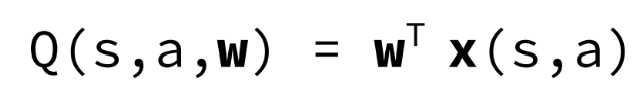

## Q function evluation

In [5]:
def evaluate_q_lvfa(env, weights, n_episodes=10, render=False):
    tile_features = TileCoding(env)
    cum_rews = []
    for ep in range(n_episodes):
        if render:
            print("################## Episode ",ep+1)
        cum_rew = 0
        done = False
        state = env.reset()
        while not done:
            # TODO choose greedy action
            # remember: weights has shape (n_actions, n_features)
            action = (weights@tile_features(state)).argmax()
            ############## simulate the action
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if render:
                print(env.ACTION_NAMES[action])
                env.render()
                print(done)
            cum_rew += reward
        cum_rews.append(cum_rew)
    mean_rew = mean(cum_rews)
    if render:
        print("Mean reward obtained in {} episodes: {} ".format( n_episodes, mean_rew))
    return mean_rew

## Q learning

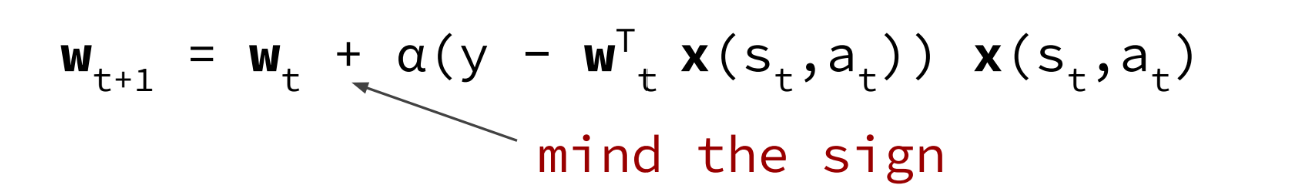

In [6]:
def q_learning(env, alpha=1.0, gamma=0.99, initial_epsilon=1.0, n_episodes=10000):
    ####### Hyperparameters
    # alpha = learning rate
    # gamma = discount factor
    # initial_epsilon = initial epsilon value
    # n_episodes = number of episodes

    tile_features = TileCoding(env)

    # Initialize weights randomly
    n_actions = env.num_actions
    n_features = env.height*env.width
    weights = np.random.random((n_actions, n_features))

    # init epsilon
    epsilon = initial_epsilon

    received_first_reward = False

    #evaluation
    evaluation_rewards = []
    mean_evaluation_rewards = []
    window = 100

    for ep in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            if random.random() < epsilon:
                #print("exploration")
                action = env.action_space.sample() # Explore action space
            else:
                #print("exploitation")
                # TODO choose greedy action
                action = (weights@tile_features(state)).argmax()

            ############## simulate the action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            #env.render()

            # TODO update weights
            y = reward + gamma * np.max(weights@tile_features(next_state))
            weights[action] += alpha*(y - (weights@tile_features(state))[action]) * tile_features(state)

            if not received_first_reward and reward > 0:
                received_first_reward = True
                print("Received first reward at episode ", ep)
            #update current state
            state = next_state

        #update current epsilon
        if received_first_reward:
            epsilon= 0.9999*epsilon

        #evaluate policy
        evaluation_rewards.append( evaluate_q_lvfa(env, weights, n_episodes=5) )
        mean_evaluation_rewards.append(mean(evaluation_rewards[-window: ]))


    plt.plot(mean_evaluation_rewards)

    print("Training finished in {} episodes\n".format(n_episodes))
    return weights


## test

In [7]:
#define the env
env = NonDeterministicGridWorld(5,5, reward_type="sparse")

Received first reward at episode  0


Training finished in 100 episodes



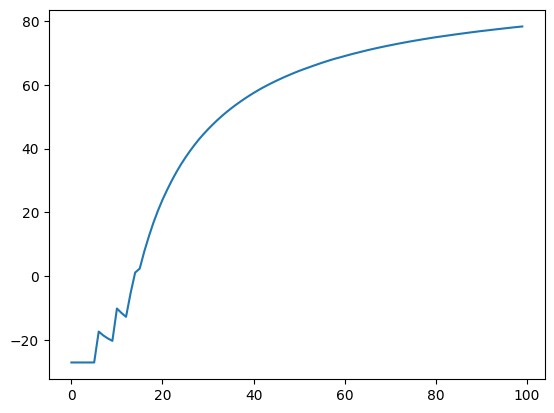

In [8]:
## Q learning
weights = q_learning(env, alpha=0.2, initial_epsilon=0.8, n_episodes=100)


## Evaluate policy

## Render the agent behaviour

In [9]:
mean_cum_rew = evaluate_q_lvfa(env, weights, render=True)

################## Episode  1
DOWN
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___| A |___|___|___|
|___|___|___|___|___|
|___|___|___|___| G |


False
DOWN
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___| A |___|___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___| A |___|___|
|___|___|___|___| G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___| A | G |


False
RIGHT
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___|___|
|___|___|___|___| A |


True
################## Episode  2
DOWN
|___|___|___|___|___|
| A |___|___|___|___|
|___|___|___|___|___|
|___|